In [1]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms

In [2]:
# Downloading and Loading Dataset
t = transforms.Compose([transforms.ToTensor()
                       ])
target_t = lambda label: F.one_hot(torch.tensor(label), num_classes=10).type(torch.float32)

train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=t, target_transform=target_t, download=True)
 
test_dataset =  datasets.FashionMNIST(root="./data", train=False, transform=t, target_transform=target_t, download=True)

classes = ["T-shirt/top",
"Trouser",
"Pullover",
"Dress",
"Coat",
"Sandal",
"Shirt",
"Sneaker",
"Bag",
"Ankle boot"] 

In [3]:
# Fitting data loaders for iterating
B_SIZE = 256

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=B_SIZE, 
                                           shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=B_SIZE,
                                          shuffle=False)

Visualizig image in dataset


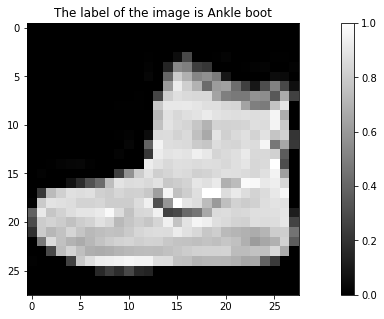

In [16]:
# img = next(iter(test_loader))[0][0].permute(1,2,0)
img = train_dataset[0][0].permute(1,2,0)
label = next(iter(test_loader))[1][0].argmax()

def visual(img, label):
    print("Visualizig image in dataset")

    fig, ax = plt.subplots()
    fig.set_size_inches(15,5)

    img = img.numpy()
    im = ax.imshow(img, cmap="gray")

    fig.colorbar(im)
    ax.set_title(f"The label of the image is {label}")
    
visual(img, classes[label])

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device):
    """ Evaluating the model for either validation or test """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in eval_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        labels = torch.argmax(labels, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    
    return accuracy, loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    epochs = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)
        epochs.append(epoch+1)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        scheduler.step()
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"    Train loss: {round(mean_loss, 5)}")
        print(f"    Valid loss: {round(loss, 5)}")
        print(f"    Accuracy: {accuracy}%")
        print("\n")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc, epochs


def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

### Implementing PyTorch LSTM model (using nn.LSTM)

In [7]:
class torch_LSTM(nn.Module):
    def __init__(self, input_dims, emd_dim, hidden_dim, num_layers, mode):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.mode = mode
        
        self.encoder = nn.Linear(in_features=input_dims, out_features=emd_dim)
        self.lstm = nn.LSTM(input_size=emd_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.classifier = nn.Linear(in_features=hidden_dim, out_features=10)
        return
    
    
    def forward(self, x):
        b_size, n_channels, n_rows, n_cols = x.shape
        h,c = self.init_state(b_size=b_size, device=x.device)
        
        x_rowed = x.view(b_size, n_channels*n_rows, n_cols)
        embeddings = self.encoder(x_rowed)
        
        lstm_out , (h_out, c_out) = self.lstm(embeddings, (h,c))
        
        y = self.classifier(lstm_out[:, -1, :])
        
        return y
    
    def init_state(self, b_size, device):
        if(self.mode == "zeros"):
            h = torch.zeros(self.num_layers, b_size, self.hidden_dim)
            c = torch.zeros(self.num_layers, b_size, self.hidden_dim)
        elif(self.mode == "random"):
            h = torch.randn(self.num_layers, b_size, self.hidden_dim)
            c = torch.randn(self.num_layers, b_size, self.hidden_dim)
        elif(self.mode == "learned"):
            h = self.learned_h.repeat(1, b_size, 1)
            c = self.learned_c.repeat(1, b_size, 1)
        h = h.to(device)
        c = c.to(device)
        return h, c

In [8]:
model_torch = torch_LSTM(input_dims=28, emd_dim=64, hidden_dim=128, num_layers=1 , mode="zeros")
model_torch=model_torch.to(device)
print(model_torch)

torch_LSTM(
  (encoder): Linear(in_features=28, out_features=64, bias=True)
  (lstm): LSTM(64, 128, batch_first=True)
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)


In [9]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model_torch.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [10]:
train_loss_lstm, val_loss_lstm, loss_iters_lstm, valid_acc_lstm, epochs_lstm = train_model(
        model=model_torch, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=20
    )

Epoch 1 Iter 235: loss 0.66519. : 100%|██████████████████████████████████████████████| 235/235 [00:36<00:00,  6.47it/s]


Epoch 1/20
    Train loss: 1.23416
    Valid loss: 2.30792
    Accuracy: 10.0%




Epoch 2 Iter 235: loss 0.51780. : 100%|██████████████████████████████████████████████| 235/235 [00:37<00:00,  6.32it/s]


Epoch 2/20
    Train loss: 0.60403
    Valid loss: 0.69008
    Accuracy: 75.4%




Epoch 3 Iter 235: loss 0.42706. : 100%|██████████████████████████████████████████████| 235/235 [00:36<00:00,  6.46it/s]


Epoch 3/20
    Train loss: 0.52069
    Valid loss: 0.55803
    Accuracy: 79.65%




Epoch 4 Iter 235: loss 0.45911. : 100%|██████████████████████████████████████████████| 235/235 [00:36<00:00,  6.47it/s]


Epoch 4/20
    Train loss: 0.47996
    Valid loss: 0.51299
    Accuracy: 81.35%




Epoch 5 Iter 235: loss 0.38651. : 100%|██████████████████████████████████████████████| 235/235 [00:36<00:00,  6.48it/s]


Epoch 5/20
    Train loss: 0.45376
    Valid loss: 0.4733
    Accuracy: 82.52000000000001%




Epoch 6 Iter 235: loss 0.46801. : 100%|██████████████████████████████████████████████| 235/235 [00:36<00:00,  6.43it/s]


Epoch 6/20
    Train loss: 0.42192
    Valid loss: 0.45644
    Accuracy: 82.98%




Epoch 7 Iter 235: loss 0.52444. : 100%|██████████████████████████████████████████████| 235/235 [00:36<00:00,  6.47it/s]


Epoch 7/20
    Train loss: 0.41545
    Valid loss: 0.44005
    Accuracy: 83.71%




Epoch 8 Iter 235: loss 0.36290. : 100%|██████████████████████████████████████████████| 235/235 [00:37<00:00,  6.20it/s]


Epoch 8/20
    Train loss: 0.41099
    Valid loss: 0.43623
    Accuracy: 83.91999999999999%




Epoch 9 Iter 235: loss 0.38067. : 100%|██████████████████████████████████████████████| 235/235 [00:37<00:00,  6.35it/s]


Epoch 9/20
    Train loss: 0.40542
    Valid loss: 0.43479
    Accuracy: 84.14%




Epoch 10 Iter 235: loss 0.26237. : 100%|█████████████████████████████████████████████| 235/235 [00:36<00:00,  6.50it/s]


Epoch 10/20
    Train loss: 0.40115
    Valid loss: 0.42966
    Accuracy: 84.16%




Epoch 11 Iter 235: loss 0.37128. : 100%|█████████████████████████████████████████████| 235/235 [00:37<00:00,  6.33it/s]


Epoch 11/20
    Train loss: 0.39348
    Valid loss: 0.4251
    Accuracy: 84.28999999999999%




Epoch 12 Iter 235: loss 0.40508. : 100%|█████████████████████████████████████████████| 235/235 [00:36<00:00,  6.46it/s]


Epoch 12/20
    Train loss: 0.39245
    Valid loss: 0.42177
    Accuracy: 84.41%




Epoch 13 Iter 235: loss 0.34848. : 100%|█████████████████████████████████████████████| 235/235 [00:37<00:00,  6.32it/s]


Epoch 13/20
    Train loss: 0.39127
    Valid loss: 0.42008
    Accuracy: 84.39%




Epoch 14 Iter 235: loss 0.44902. : 100%|█████████████████████████████████████████████| 235/235 [00:37<00:00,  6.24it/s]


Epoch 14/20
    Train loss: 0.39068
    Valid loss: 0.41997
    Accuracy: 84.47%




Epoch 15 Iter 235: loss 0.52681. : 100%|█████████████████████████████████████████████| 235/235 [00:36<00:00,  6.39it/s]


Epoch 15/20
    Train loss: 0.38991
    Valid loss: 0.41896
    Accuracy: 84.5%




Epoch 16 Iter 235: loss 0.50334. : 100%|█████████████████████████████████████████████| 235/235 [00:37<00:00,  6.19it/s]


Epoch 16/20
    Train loss: 0.38827
    Valid loss: 0.41767
    Accuracy: 84.58%




Epoch 17 Iter 235: loss 0.30314. : 100%|█████████████████████████████████████████████| 235/235 [00:37<00:00,  6.22it/s]


Epoch 17/20
    Train loss: 0.38734
    Valid loss: 0.41729
    Accuracy: 84.53%




Epoch 18 Iter 235: loss 0.36496. : 100%|█████████████████████████████████████████████| 235/235 [00:37<00:00,  6.33it/s]


Epoch 18/20
    Train loss: 0.38732
    Valid loss: 0.41725
    Accuracy: 84.53%




Epoch 19 Iter 235: loss 0.44436. : 100%|█████████████████████████████████████████████| 235/235 [00:36<00:00,  6.36it/s]


Epoch 19/20
    Train loss: 0.38734
    Valid loss: 0.41704
    Accuracy: 84.55%




Epoch 20 Iter 235: loss 0.40662. : 100%|█████████████████████████████████████████████| 235/235 [00:36<00:00,  6.49it/s]

Epoch 20/20
    Train loss: 0.38707
    Valid loss: 0.4171
    Accuracy: 84.50999999999999%


Training completed


### Implementing own custom LSTM model without using nn.LSTM

In [11]:
class LSTM_Cells(torch.nn.Module):
   
    def __init__(self, in_dim, hidden_dim, bias=True):
        super(LSTM_Cells, self).__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.bias = bias
        self.layer1 = nn.Linear(in_dim, 4 * hidden_dim, bias=bias)
        self.layer2 = nn.Linear(hidden_dim, 4 * hidden_dim, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_dim)
        for w in self.parameters():
            w.data.uniform_(-std, std)
    
    def forward(self, x, hidden):
        
        x = x.view(-1, x.size(1))
        hx, cx = hidden
        
        gates = self.layer1(x) + self.layer2(hx)
        gates = gates.squeeze()
        
        input_gate, forget_gate, next_gate, out_gate = gates.chunk(4, 1)
        
        input_gate = torch.sigmoid(input_gate)
        
        forget_gate = torch.sigmoid(forget_gate)
        
        next_gate = torch.tanh(next_gate)
        
        out_gate = torch.sigmoid(out_gate)  
        
        c_y = forget_gate * cx + input_gate * next_gate
        h_y = out_gate * torch.tanh(c_y)
        
        return (c_y, h_y)
class Custom_LSTM(nn.Module):
    """ 
    Sequential classifier for images. Embedded image rows are fed to a RNN
    
    Args:
    -----
    input_dim: integer
        dimensionality of the rows to embed
    emb_dim: integer 
        dimensionality of the vectors fed to the LSTM
    hidden_dim: integer
        dimensionality of the states in the cell
    num_layers: integer
        number of stacked LSTMS
    mode: string
        intialization of the states
    """
    
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers=1, mode="zeros"):
        """ Module initializer """
        assert mode in ["zeros", "random", "learned"]
        super().__init__()
        self.hidden_dim =  hidden_dim
        self.input_dim =  input_dim
        self.num_layers = num_layers
        self.mode = mode
        if(mode == "learned"):
            self.learned_h = nn.Parameter(
                    torch.randn(num_layers, 1, hidden_dim).requires_grad_()
                )
            self.learned_c = nn.Parameter(
                    torch.randn(num_layers, 1, hidden_dim).requires_grad_()
                )
        
        # for embedding rows into vector representations
        self.encoder = nn.Linear(in_features=input_dim, out_features=emb_dim)

        lstms = []
        for i in range(num_layers):
            in_size = emb_dim if i == 0 else hidden_dim
            lstms.append(LSTM_Cells(in_dim=in_size, hidden_dim=hidden_dim))
        self.lstm = nn.ModuleList(lstms)
        
        # classifier
        self.classifier = nn.Linear(in_features=hidden_dim, out_features=10)
        
        return
    

    def forward(self, x):
        """ Forward pass through model """
        
        b_size, n_channels, n_rows, n_cols = x.shape
        h, c = self.init_state(b_size=b_size, device=x.device) 
        
        # embedding rows
        x_rowed = x.view(b_size, n_channels*n_rows, n_cols)

        embeddings = self.encoder(x_rowed)


        lstm_out = []
        for i in range(embeddings.shape[1]):
            lstm_input = embeddings[:, i, :]
            # iterating over LSTM Cells
            for j, lstm_cell in enumerate(self.lstm):
                h[j], c[j] = lstm_cell(lstm_input, (h[j].clone(), c[j].clone()))
                lstm_input = h[j]
            lstm_out.append(lstm_input)
        lstm_out = torch.stack(lstm_out, dim=1)

        # classifying
        y = self.classifier(lstm_out[:, -1, :])  # feeding only output at last layer
        return y
    
        
    def init_state(self, b_size, device):
        """ Initializing hidden and cell state """
        if(self.mode == "zeros"):
            h = torch.zeros(self.num_layers, b_size, self.hidden_dim)
            c = torch.zeros(self.num_layers, b_size, self.hidden_dim)
        elif(self.mode == "random"):
            h = torch.randn(self.num_layers, b_size, self.hidden_dim)
            c = torch.randn(self.num_layers, b_size, self.hidden_dim)
        elif(self.mode == "learned"):
            h = self.learned_h.repeat(1, b_size, 1)
            c = self.learned_c.repeat(1, b_size, 1)
        h = h.to(device)
        c = c.to(device)
        return h, c

In [12]:
model_customlstm = Custom_LSTM(input_dim=28, emb_dim=64, hidden_dim=128, num_layers=1, mode="zeros")
count_model_params(model_customlstm)

102474

In [13]:
model_customlstm = model_customlstm.to(device)
print(model_customlstm)

Custom_LSTM(
  (encoder): Linear(in_features=28, out_features=64, bias=True)
  (lstm): ModuleList(
    (0): LSTM_Cells(
      (layer1): Linear(in_features=64, out_features=512, bias=True)
      (layer2): Linear(in_features=128, out_features=512, bias=True)
    )
  )
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)


In [14]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model_customlstm.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [15]:
train_loss_cuslstm, val_loss_cuslstm, loss_iters_cuslstm, valid_acc_cuslstm, epochs_cuslstm = train_model(
        model=model_customlstm, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=20
    )

Epoch 1 Iter 235: loss 0.81441. : 100%|██████████████████████████████████████████████| 235/235 [00:59<00:00,  3.97it/s]


Epoch 1/20
    Train loss: 1.26764
    Valid loss: 2.30494
    Accuracy: 10.32%




Epoch 2 Iter 235: loss 0.55637. : 100%|██████████████████████████████████████████████| 235/235 [00:59<00:00,  3.97it/s]


Epoch 2/20
    Train loss: 0.68665
    Valid loss: 0.78817
    Accuracy: 69.89999999999999%




Epoch 3 Iter 235: loss 0.44169. : 100%|██████████████████████████████████████████████| 235/235 [00:59<00:00,  3.95it/s]


Epoch 3/20
    Train loss: 0.57337
    Valid loss: 0.6347
    Accuracy: 75.71%




Epoch 4 Iter 235: loss 0.51653. : 100%|██████████████████████████████████████████████| 235/235 [00:58<00:00,  4.01it/s]


Epoch 4/20
    Train loss: 0.51399
    Valid loss: 0.547
    Accuracy: 79.49000000000001%




Epoch 5 Iter 235: loss 0.43215. : 100%|██████████████████████████████████████████████| 235/235 [00:59<00:00,  3.97it/s]


Epoch 5/20
    Train loss: 0.48376
    Valid loss: 0.55849
    Accuracy: 78.96%




Epoch 6 Iter 235: loss 0.44699. : 100%|██████████████████████████████████████████████| 235/235 [00:57<00:00,  4.12it/s]


Epoch 6/20
    Train loss: 0.44223
    Valid loss: 0.48266
    Accuracy: 82.04%




Epoch 7 Iter 235: loss 0.30767. : 100%|██████████████████████████████████████████████| 235/235 [01:00<00:00,  3.91it/s]


Epoch 7/20
    Train loss: 0.43372
    Valid loss: 0.45681
    Accuracy: 83.1%




Epoch 8 Iter 235: loss 0.51533. : 100%|██████████████████████████████████████████████| 235/235 [00:58<00:00,  3.99it/s]


Epoch 8/20
    Train loss: 0.42964
    Valid loss: 0.45649
    Accuracy: 83.35000000000001%




Epoch 9 Iter 235: loss 0.27995. : 100%|██████████████████████████████████████████████| 235/235 [00:59<00:00,  3.95it/s]


Epoch 9/20
    Train loss: 0.42448
    Valid loss: 0.45546
    Accuracy: 83.31%




Epoch 10 Iter 235: loss 0.43528. : 100%|█████████████████████████████████████████████| 235/235 [00:59<00:00,  3.97it/s]


Epoch 10/20
    Train loss: 0.42105
    Valid loss: 0.44764
    Accuracy: 83.62%




Epoch 11 Iter 235: loss 0.27694. : 100%|█████████████████████████████████████████████| 235/235 [00:58<00:00,  3.98it/s]


Epoch 11/20
    Train loss: 0.4114
    Valid loss: 0.44053
    Accuracy: 84.02%




Epoch 12 Iter 235: loss 0.52280. : 100%|█████████████████████████████████████████████| 235/235 [00:59<00:00,  3.97it/s]


Epoch 12/20
    Train loss: 0.41074
    Valid loss: 0.43634
    Accuracy: 83.88%




Epoch 13 Iter 235: loss 0.37634. : 100%|█████████████████████████████████████████████| 235/235 [00:58<00:00,  3.98it/s]


Epoch 13/20
    Train loss: 0.40959
    Valid loss: 0.43576
    Accuracy: 84.05%




Epoch 14 Iter 235: loss 0.35303. : 100%|█████████████████████████████████████████████| 235/235 [01:00<00:00,  3.89it/s]


Epoch 14/20
    Train loss: 0.40835
    Valid loss: 0.43588
    Accuracy: 83.94%




Epoch 15 Iter 235: loss 0.35433. : 100%|█████████████████████████████████████████████| 235/235 [00:58<00:00,  3.99it/s]


Epoch 15/20
    Train loss: 0.408
    Valid loss: 0.43663
    Accuracy: 83.91999999999999%




Epoch 16 Iter 235: loss 0.33446. : 100%|█████████████████████████████████████████████| 235/235 [01:01<00:00,  3.80it/s]


Epoch 16/20
    Train loss: 0.40572
    Valid loss: 0.43424
    Accuracy: 84.02%




Epoch 17 Iter 235: loss 0.57805. : 100%|█████████████████████████████████████████████| 235/235 [01:00<00:00,  3.90it/s]


Epoch 17/20
    Train loss: 0.40612
    Valid loss: 0.43289
    Accuracy: 84.13000000000001%




Epoch 18 Iter 235: loss 0.42534. : 100%|█████████████████████████████████████████████| 235/235 [00:59<00:00,  3.98it/s]


Epoch 18/20
    Train loss: 0.4055
    Valid loss: 0.43277
    Accuracy: 84.05%




Epoch 19 Iter 235: loss 0.42056. : 100%|█████████████████████████████████████████████| 235/235 [00:58<00:00,  3.98it/s]


Epoch 19/20
    Train loss: 0.40525
    Valid loss: 0.43272
    Accuracy: 84.11999999999999%




Epoch 20 Iter 235: loss 0.35088. : 100%|█████████████████████████████████████████████| 235/235 [00:59<00:00,  3.96it/s]

Epoch 20/20
    Train loss: 0.40483
    Valid loss: 0.43247
    Accuracy: 84.05%


Training completed


### Learning curves of the model trained using Pytorch LSTM and custom LSTM
#TODO
Add conv LSTM


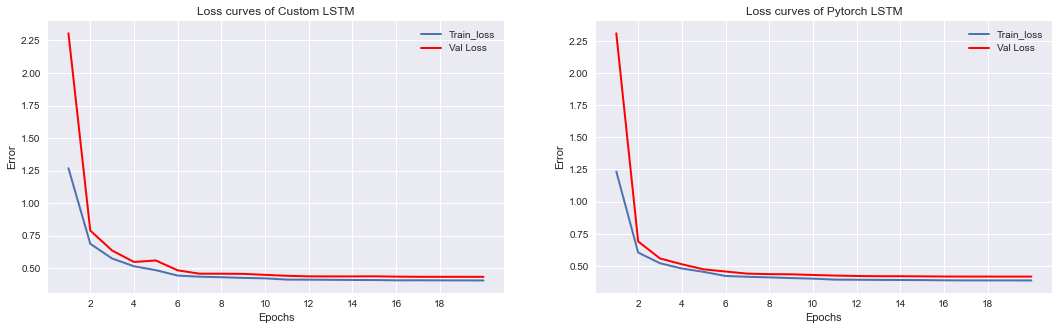

In [17]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18, 5)

ax[0].plot(epochs_cuslstm, train_loss_cuslstm, label="Train_loss", linewidth=2)
ax[0].plot(epochs_cuslstm, val_loss_cuslstm, label="Val Loss", c='red', linewidth=2)
ax[0].legend(loc='best')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Error")
ax[0].set_xticks(np.arange(2, 19, step=2))

ax[0].set_title("Loss curves of Custom LSTM")

ax[1].plot(epochs_lstm, train_loss_lstm, label="Train_loss", linewidth=2)
ax[1].plot(epochs_lstm, val_loss_lstm , label="Val Loss", c='red', linewidth=2)
ax[1].legend(loc='best')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Error")
ax[1].set_xticks(np.arange(2, 19, step=2))

ax[1].set_title("Loss curves of Pytorch LSTM")


plt.show()

The curves show that the models have learned quite well and reach a stability point. The custom LSTM model works at par with Pytorchs inbuilt LSTM. However, it takes a little more time to reach stability(very minimal, almost negligible).


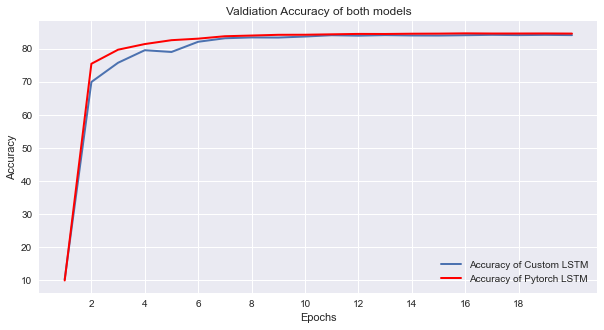

In [18]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 5)

ax.plot(epochs_cuslstm, valid_acc_cuslstm, linewidth=2,label="Accuracy of Custom LSTM")
ax.plot(epochs_lstm, valid_acc_lstm, label="Accuracy of Pytorch LSTM",c='red', linewidth=2)
ax.legend(loc='best')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_xticks(np.arange(2, 19, step=2))

ax.set_title(f"Valdiation Accuracy of both models")

plt.show()

Pytorch LSTM model reaches an accuracy of 84.5% while the custom LSTM reaches a maximum accuracy of 84.1%. 

### Implementing GRU

In [19]:
class GRU(nn.Module):

    def __init__(self, in_dim, hidden_dim, bias=True):
        super(GRU, self).__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.bias = bias
        self.layer1 = nn.Linear(in_dim, 3 * hidden_dim, bias=bias)
        self.layer2 = nn.Linear(hidden_dim, 3 * hidden_dim, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_dim)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hidden):

        x = x.view(-1, x.size(1))

        gate_x = self.layer1(x) 
        gate_h = self.layer2(hidden)

        gate_x = gate_x.squeeze()
        gate_h = gate_h.squeeze()
        i_r, i_i, i_n = gate_x.chunk(3, 1)
        h_r, h_i, h_n = gate_h.chunk(3, 1)


        reset_gate = torch.sigmoid(i_r + h_r)
        update_gate = torch.sigmoid(i_i + h_i)
        next_gate = torch.tanh(i_n + (reset_gate * h_n))

        h_y = next_gate + update_gate * (hidden - next_gate)

        return h_y

#create GRU model class
class GRUModel(nn.Module):
    def __init__(self, in_dim, emb_dim, hidden_dim, num_layers, out_size, bias=True, mode="zeros"):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.mode = mode
        self.encoder = nn.Linear(in_features=in_dim, out_features=emb_dim)
        
        grus = []
        for i in range(num_layers):
            in_size = emb_dim if i == 0 else hidden_dim
            grus.append(GRU(in_dim=in_size, hidden_dim=hidden_dim))
        self.gru = nn.ModuleList(grus)
        
        # classifier
        self.fc = nn.Linear(hidden_dim, out_size)
        
    def init_state(self, b_size, device):
        """ Initializing hidden and cell state """
        if(self.mode == "zeros"):
            h = torch.zeros(self.num_layers,b_size, self.hidden_dim).to(device) 
            c = torch.zeros(self.num_layers,b_size, self.hidden_dim).to(device) 
        elif(self.mode == "random"):
            h = torch.zeros(self.num_layers,b_size, self.hidden_dim).to(device) 
            c = torch.zeros(self.num_layers,b_size, self.hidden_dim).to(device) 
        return h, c
    
    
    def forward(self, x):
        b_size, n_channels, n_rows, n_cols = x.shape
        # Initialize hidden state with zeros
        h, c = self.init_state(b_size=b_size, device=x.device) 
        
        # embedding rows
        x_rowed = x.view(b_size, n_channels*n_rows, n_cols)

        embeddings = self.encoder(x_rowed)
        
        out = []
        for i in range(embeddings.shape[1]):
            gru_input = embeddings[:, i, :]
            # iterating over GRU Cells
            for j, lstm_cell in enumerate(self.gru):
                h[j] = lstm_cell(gru_input, (h[j].clone()))
                gru_input = h[j]
            out.append(gru_input)
        out = torch.stack(out, dim=1)

        # classifying
        y = self.fc(out[:, -1, :])  # feeding only output at last layer
        return y
        

In [20]:
model_GRU = GRUModel(in_dim=28, emb_dim=64, hidden_dim=128, num_layers=1,out_size=10, mode="zeros")
count_model_params(model_GRU)

77642

In [21]:
model_GRU = model_GRU.to(device)
print(model_GRU)

GRUModel(
  (encoder): Linear(in_features=28, out_features=64, bias=True)
  (gru): ModuleList(
    (0): GRU(
      (layer1): Linear(in_features=64, out_features=384, bias=True)
      (layer2): Linear(in_features=128, out_features=384, bias=True)
    )
  )
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


In [22]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model_GRU.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [23]:
train_loss_gru, val_loss_gru, loss_iters_gru, valid_acc_gru, epochs_gru = train_model(
        model=model_GRU, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=20
    )

Epoch 1 Iter 235: loss 0.94428. : 100%|██████████████████████████████████████████████| 235/235 [00:56<00:00,  4.12it/s]


Epoch 1/20
    Train loss: 1.39716
    Valid loss: 2.30364
    Accuracy: 8.34%




Epoch 2 Iter 235: loss 0.70401. : 100%|██████████████████████████████████████████████| 235/235 [00:57<00:00,  4.09it/s]


Epoch 2/20
    Train loss: 0.76485
    Valid loss: 0.89537
    Accuracy: 67.01%




Epoch 3 Iter 235: loss 0.43433. : 100%|██████████████████████████████████████████████| 235/235 [00:58<00:00,  4.01it/s]


Epoch 3/20
    Train loss: 0.61834
    Valid loss: 0.68966
    Accuracy: 73.29%




Epoch 4 Iter 235: loss 0.51473. : 100%|██████████████████████████████████████████████| 235/235 [00:57<00:00,  4.07it/s]


Epoch 4/20
    Train loss: 0.55144
    Valid loss: 0.58989
    Accuracy: 77.47%




Epoch 5 Iter 235: loss 0.56007. : 100%|██████████████████████████████████████████████| 235/235 [00:57<00:00,  4.08it/s]


Epoch 5/20
    Train loss: 0.50612
    Valid loss: 0.53458
    Accuracy: 79.86999999999999%




Epoch 6 Iter 235: loss 0.60247. : 100%|██████████████████████████████████████████████| 235/235 [00:56<00:00,  4.15it/s]


Epoch 6/20
    Train loss: 0.47282
    Valid loss: 0.49645
    Accuracy: 81.38%




Epoch 7 Iter 235: loss 0.53065. : 100%|██████████████████████████████████████████████| 235/235 [00:56<00:00,  4.14it/s]


Epoch 7/20
    Train loss: 0.46393
    Valid loss: 0.48309
    Accuracy: 82.35%




Epoch 8 Iter 235: loss 0.40967. : 100%|██████████████████████████████████████████████| 235/235 [00:56<00:00,  4.14it/s]


Epoch 8/20
    Train loss: 0.45666
    Valid loss: 0.47222
    Accuracy: 82.89999999999999%




Epoch 9 Iter 235: loss 0.40404. : 100%|██████████████████████████████████████████████| 235/235 [00:57<00:00,  4.11it/s]


Epoch 9/20
    Train loss: 0.44902
    Valid loss: 0.46909
    Accuracy: 82.93%




Epoch 10 Iter 235: loss 0.43162. : 100%|█████████████████████████████████████████████| 235/235 [00:56<00:00,  4.15it/s]


Epoch 10/20
    Train loss: 0.44241
    Valid loss: 0.46056
    Accuracy: 83.24000000000001%




Epoch 11 Iter 235: loss 0.37875. : 100%|█████████████████████████████████████████████| 235/235 [00:57<00:00,  4.09it/s]


Epoch 11/20
    Train loss: 0.43617
    Valid loss: 0.45428
    Accuracy: 83.23%




Epoch 12 Iter 235: loss 0.37876. : 100%|█████████████████████████████████████████████| 235/235 [00:56<00:00,  4.14it/s]


Epoch 12/20
    Train loss: 0.43445
    Valid loss: 0.45066
    Accuracy: 83.67999999999999%




Epoch 13 Iter 235: loss 0.32705. : 100%|█████████████████████████████████████████████| 235/235 [00:56<00:00,  4.13it/s]


Epoch 13/20
    Train loss: 0.43316
    Valid loss: 0.44919
    Accuracy: 83.67999999999999%




Epoch 14 Iter 235: loss 0.41808. : 100%|█████████████████████████████████████████| 235/235 [11:48:48<00:00, 180.97s/it]


Epoch 14/20
    Train loss: 0.43211
    Valid loss: 0.44777
    Accuracy: 83.75%




Epoch 15 Iter 235: loss 0.31176. : 100%|█████████████████████████████████████████████| 235/235 [00:30<00:00,  7.66it/s]


Epoch 15/20
    Train loss: 0.43068
    Valid loss: 0.44686
    Accuracy: 83.67999999999999%




Epoch 16 Iter 235: loss 0.38403. : 100%|█████████████████████████████████████████████| 235/235 [00:33<00:00,  7.11it/s]


Epoch 16/20
    Train loss: 0.42971
    Valid loss: 0.44529
    Accuracy: 83.67999999999999%




Epoch 17 Iter 235: loss 0.42646. : 100%|█████████████████████████████████████████████| 235/235 [01:04<00:00,  3.65it/s]


Epoch 17/20
    Train loss: 0.42952
    Valid loss: 0.44531
    Accuracy: 83.78999999999999%




Epoch 18 Iter 235: loss 0.44656. : 100%|█████████████████████████████████████████████| 235/235 [01:05<00:00,  3.58it/s]


Epoch 18/20
    Train loss: 0.42932
    Valid loss: 0.44492
    Accuracy: 83.76%




Epoch 19 Iter 235: loss 0.39831. : 100%|█████████████████████████████████████████████| 235/235 [01:08<00:00,  3.41it/s]


Epoch 19/20
    Train loss: 0.42894
    Valid loss: 0.44475
    Accuracy: 83.83%




Epoch 20 Iter 235: loss 0.48688. : 100%|█████████████████████████████████████████████| 235/235 [00:58<00:00,  4.01it/s]

Epoch 20/20
    Train loss: 0.42893
    Valid loss: 0.44456
    Accuracy: 83.85000000000001%


Training completed


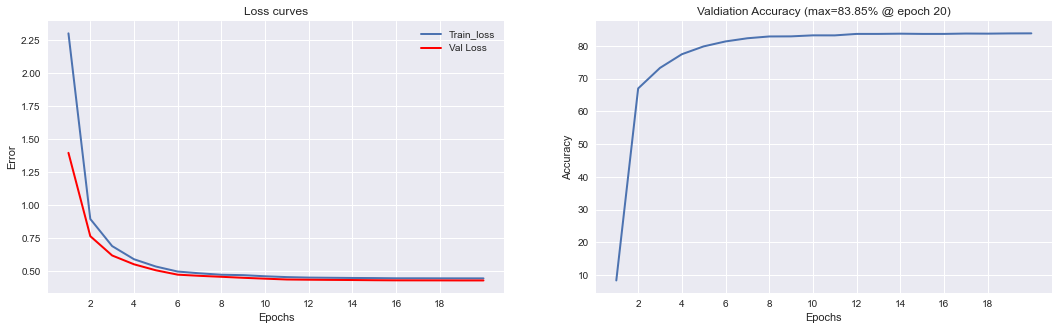

In [24]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18, 5)

ax[0].plot(epochs_gru, val_loss_gru, label="Train_loss", linewidth=2)
ax[0].plot(epochs_gru, train_loss_gru, label="Val Loss", c='red', linewidth=2)
ax[0].legend(loc='best')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Error")
ax[0].set_xticks(np.arange(2, 19, step=2))

ax[0].set_title("Loss curves")


ax[1].plot(epochs_gru, valid_acc_gru, label="Accuracy", linewidth=2)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_xticks(np.arange(2, 19, step=2))

ax[1].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc_gru),2)}% @ epoch {np.argmax(valid_acc_gru)+1})")

plt.show()

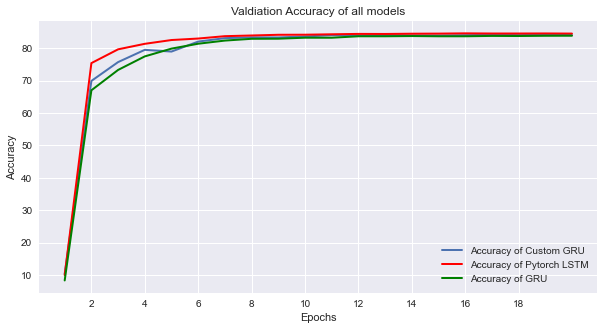

In [25]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 5)

ax.plot(epochs_cuslstm, valid_acc_cuslstm, linewidth=2,label="Accuracy of Custom GRU")
ax.plot(epochs_lstm, valid_acc_lstm, label="Accuracy of Pytorch LSTM",c='red', linewidth=2)
ax.plot(epochs_gru, valid_acc_gru, label="Accuracy of GRU",c='green', linewidth=2)
ax.legend(loc='best')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_xticks(np.arange(2, 19, step=2))

ax.set_title(f"Valdiation Accuracy of all models")

plt.show()

Model trained with GRU achieves almost the same results as the model trained using Pytorchs LSTM.

## References
https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091
